
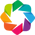

In [1]:
import holoviews as hv
hv.notebook_extension('bokeh')

In [2]:
from param import ParameterizedFunction, ParamOverrides
from holoviews.core.operation import Operation
from holoviews.operation.datashader import datashade, dynspread
import colorcet as cc
import datashader as ds

In [3]:
import dask
import dask.dataframe as dd
import pandas as pd
from distributed import Client
client = Client(scheduler_file='/scratch/tmorton/dask/scheduler.json')

In [4]:
import sys
sys.path.append('..')

from explorer.catalog import ParquetCatalog, MatchedCatalog

def get_coadd(rerun, filt, tracts, unforced=False):
    table = 'unforced' if unforced else 'forced'
    files = ['{}/plots/{}/tract-{}/{}.parq'.format(rerun, filt, t, table) for t in tracts]
    return ParquetCatalog(files)
    
def get_visit(rerun, filt, tract, visit):
    file = '{}/plots/{}/tract-{}/visit-{}/catalog.parq'.format(rerun, filt, tract, visit)
    return ParquetCatalog([file])

In [5]:
rerun = '/scratch/tmorton/hscRerun/DM-12043/SSP_DEEP_XMM_LSS'
filt = 'HSC-Y'
tract = 8767
visit = 39308
coadd_cat = get_coadd(rerun, filt, [tract])
visit_cat = get_visit(rerun, filt, tract, visit)
matched = MatchedCatalog(coadd_cat, visit_cat)

In [17]:
from explorer.dataset import QADataset
from explorer.functors import (Mag, MagDiff, CustomFunctor, DeconvolvedMoments, Column,
                            SdssTraceSize, PsfSdssTraceSizeDiff, HsmTraceSize,
                            PsfHsmTraceSizeDiff, CompositeFunctor)

f = MagDiff('modelfit_CModel', 'base_PsfFlux')
mag = Mag('base_PsfFlux')

In [6]:
from explorer.utils import get_visits

In [7]:
visits = get_visits('DEEP', tract, filt)

In [8]:
visits

[16046,
 16048,
 16050,
 16052,
 16074,
 16078,
 16080,
 16116,
 39290,
 39294,
 39296,
 39300,
 39302,
 39306,
 39308]

In [13]:
visit_cats = [get_visit(rerun, filt, tract, v) for v in visits]

In [14]:
matched_cats = [MatchedCatalog(coadd_cat, v) for v in visit_cats]

In [31]:
data = {}
for v in visits:
    try:
        visit_cat = get_visit(rerun, filt, tract, v)
        matched = MatchedCatalog(coadd_cat, visit_cat)
        matched.match()
        data[v] = QADataset(matched, mag)
        print(len(data[v].ds))
    except KeyError:
        raise
    except:
        continue

28806 good matches, 579205 bad.
28791
45263 good matches, 562748 bad.
45242
46896 good matches, 561115 bad.
46829
63093 good matches, 544918 bad.
63037
62254 good matches, 545757 bad.
62207
76233 good matches, 531778 bad.
76202
82639 good matches, 525372 bad.
82608
73956 good matches, 534055 bad.
73936
11004 good matches, 597007 bad.
10995
74187 good matches, 533824 bad.
74143


In [ ]:
class VisitMatchQADataset(QADataset):
    def __init__(self, coadd_cat, visit_cats, funcs, **kwargs):
        

In [27]:
data

{16050: <explorer.dataset.QADataset at 0x7f13fd9c5a20>,
 16052: <explorer.dataset.QADataset at 0x7f140282a470>,
 16074: <explorer.dataset.QADataset at 0x7f13fd96ea90>,
 16080: <explorer.dataset.QADataset at 0x7f13fd967f60>,
 16116: <explorer.dataset.QADataset at 0x7f13fdae4978>,
 39290: <explorer.dataset.QADataset at 0x7f13fd9758d0>,
 39296: <explorer.dataset.QADataset at 0x7f13fdadfda0>,
 39302: <explorer.dataset.QADataset at 0x7f13fd9739b0>,
 39306: <explorer.dataset.QADataset at 0x7f13fd9818d0>,
 39308: <explorer.dataset.QADataset at 0x7f13fd97c780>}

In [24]:
import param

class skyplot(Operation):
    """Pass pts with ra,dec as kdims
    """
    cmap = param.String(default='coolwarm')
    aggregator = param.ObjectSelector(default='mean', objects=['mean', 'std', 'count'])
    vdim = param.String(default=None)
    width = param.Number(default=None)
    height = param.Number(default=None)
    streams = param.List(default=None)
    sampling = param.Number(default=None)
    
    def _process(self, dset, key=None):
        if self.p.vdim is None:
            vdim = dset.vdims[0].name
        else:
            vdim = self.p.vdim
        pts = hv.Points(dset, kdims=['ra', 'dec'], vdims=[vdim])
        
        if self.p.aggregator == 'mean':
            aggregator = ds.mean(vdim)
        elif self.p.aggregator == 'std':
            aggregator = ds.std(vdim)
        elif self.p.aggregator == 'count':
            aggregator = ds.count()
        
        kwargs = dict(cmap=cc.palette[self.p.cmap],
                      aggregator=aggregator)
        if self.p.width is not None:
            kwargs.update(width=self.p.width, height=self.p.height,
                         streams=[hv.streams.RangeXY])
            
        sky_shaded = datashade(pts, **kwargs)
        return dynspread(sky_shaded)

In [32]:
holomap = hv.HoloMap(kdims=['visit'])

for v,d in data.items():
    holomap[v] = skyplot(d.ds)

In [35]:
sky_plots = {v:skyplot(d.ds) for v,d in data.items()}

In [36]:
sky_plots

{16050: :DynamicMap   [],
 16052: :DynamicMap   [],
 16074: :DynamicMap   [],
 16080: :DynamicMap   [],
 16116: :DynamicMap   [],
 39290: :DynamicMap   [],
 39296: :DynamicMap   [],
 39302: :DynamicMap   [],
 39306: :DynamicMap   [],
 39308: :DynamicMap   []}

In [37]:
holomap = hv.HoloMap(sky_plots, kdims=['visit'])

In [46]:
%%opts Overlay[tabs=True] RGB [width=400, height=400]

hv.Layout([s for s in sky_plots.values()]).cols(4)

:Layout
   .DynamicMap.I    :DynamicMap   []
      :RGB   [ra,dec]   (R,G,B,A)
   .DynamicMap.II   :DynamicMap   []
      :RGB   [ra,dec]   (R,G,B,A)
   .DynamicMap.III  :DynamicMap   []
      :RGB   [ra,dec]   (R,G,B,A)
   .DynamicMap.IV   :DynamicMap   []
      :RGB   [ra,dec]   (R,G,B,A)
   .DynamicMap.V    :DynamicMap   []
      :RGB   [ra,dec]   (R,G,B,A)
   .DynamicMap.VI   :DynamicMap   []
      :RGB   [ra,dec]   (R,G,B,A)
   .DynamicMap.VII  :DynamicMap   []
      :RGB   [ra,dec]   (R,G,B,A)
   .DynamicMap.VIII :DynamicMap   []
      :RGB   [ra,dec]   (R,G,B,A)
   .DynamicMap.IX   :DynamicMap   []
      :RGB   [ra,dec]   (R,G,B,A)
   .DynamicMap.X    :DynamicMap   []
      :RGB   [ra,dec]   (R,G,B,A)

In [138]:
data = QADataset(coadd_cat, mag)

In [139]:
data.ds

:Dataset   [ra,dec,x,label]   (y0)

In [149]:
%%opts RGB [width=1200, height=600]
from holoviews.streams import RangeXY
# width=None; height=None; 
width=100; height=50
skyplot.instance(width=width, height=height)(data.ds)

:DynamicMap   []